In [2]:
# std packages
%matplotlib inline
import numpy as np
import scipy.interpolate as interp
import scipy.signal as sig
import scipy.optimize as opt
import scipy.integrate as integ
import scipy.linalg as sla
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d as g_filt
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
from matplotlib.ticker import LogLocator
import h5py as h5
import os

import corner

plt.rc('figure', figsize=(9, 7))
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.serif': ['Georgia'],
                     'mathtext.fontset': 'cm',
                     'lines.linewidth': 2.5,
                     'font.size': 20,
                     'xtick.labelsize': 'large',
                     'ytick.labelsize': 'large',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'axes.labelsize': 'large',
                     'axes.titlesize': 'large',
                     'axes.grid': True,
                     'grid.alpha': 0.5,
                     'lines.markersize': 12,
                     'legend.borderpad': 0.2,
                     'legend.fancybox': True,
                     'legend.fontsize': 'large',
                     'legend.framealpha': 0.7,
                     'legend.handletextpad': 0.5,
                     'legend.labelspacing': 0.2,
                     'legend.loc': 'best',
                     'savefig.bbox': 'tight',
                     'savefig.pad_inches': 0.05,
                     'savefig.dpi': 80,
                     'pdf.compression': 9})

from myConstants import *

In [3]:
def get_inst_t_gw_from_a_orb(M1, M2, a_orb, e):
    Mt=M1+M2
    mu=M1*M2/(M1+M2)
    
    G3muMt2_c5a3 = (G*mu/c**2./a_orb) * (G*Mt/c**2./a_orb)**2. * c
    
    inv_t_gw = (64./5.)*(G3muMt2_c5a3/a_orb) \
                * (1.+73./24.*e**2+37./96.*e**4.)/(1.-e**2.)**(3.5)
    t_gw = 1./inv_t_gw
    return t_gw

def get_angles(J, L, e, S, par):
    M1, M2, S1, S2, chi_eff = par
    
    qq=M2/M1
    Mt=M1+M2
    
    c_th1 = 0.5 * 1./((1.-qq)*S1) * \
        ((J**2. - L**2. - S**2.)/L  - 2.*qq*G*Mt**2./c*chi_eff/(1.+qq))
    c_th2 = 0.5 * qq/((1.-qq)*S2) * \
        (-(J**2.-L**2.-S**2.)/L + 2.*G*Mt**2./c*chi_eff/(1.+qq))
    c_th12 = (S**2. - S1**2. -S2**2.)/(2.*S1*S2)
    
    th1, th2, th12 = np.arccos(c_th1), np.arccos(c_th2), np.arccos(c_th12)
    c_dphi = (c_th12 - c_th1*c_th2)/(np.sin(th1) * np.sin(th2))
    dphi = np.arccos(c_dphi)
    return th1, th2, th12, dphi

def get_dSdt(J, L, e, S, par):
    M1, M2, S1, S2, chi_eff = par
    
    qq=M2/M1
    Mt=M1+M2
    mu=M1*M2/Mt
    eta=mu/Mt
    eff = np.sqrt(1.-e**2.)
    
    th1, th2, th12, dphi = get_angles(J, L, e, S, par)
    
    dSdt = 1.5*eta**6. * eff**3. * (1-qq**2.)/qq * ((G*Mt**2./c)/L)**5.\
        * (c**3./G/Mt) * (S1*S2/S)\
        * (-1. + 0.5*qq/(1.-qq)**2.*(J**2.-L**2.-S**2.)/L**2. \
          - 2.*qq**2./(1.-qq**2.)**2.*G*Mt**2./c/L*chi_eff)\
        * np.sin(th1) * np.sin(th2) * np.sin(dphi)
    return dSdt

def find_Smp(J, L, e, par, nPt=8000):
    M1, M2, S1, S2, chi_eff = par
    qq=M2/M1
    Mt=M1+M2
    S_unit = G*Mt**2./c
    
    S_min = np.max([np.abs(J-L), np.abs(S1-S2)])
    S_max = np.min([J+L, S1+S2])
    S_vect = np.linspace(S_min, S_max, nPt)
    
    A1=np.sqrt(J**2. - (L-S_vect)**2.)
    A2=np.sqrt((L+S_vect)**2. - J**2.)
    A3=np.sqrt(S_vect**2. - (S1-S2)**2.)
    A4=np.sqrt((S1+S2)**2. - S_vect**2.)
    
    chi_vect1 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 -(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)

    chi_vect2 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 +(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)
    
    # note here is S vs chi-chi_eff!
    chi_vs_S_func1 = interp.interp1d(S_vect.squeeze(), chi_vect1.squeeze()-chi_eff)
    chi_vs_S_func2 = interp.interp1d(S_vect.squeeze(), chi_vect2.squeeze()-chi_eff)
    
    idx1 = np.argmin(chi_vect1)
    idx2 = np.argmax(chi_vect2)
    
    if np.max(chi_vect1) < chi_eff:
        Sm = opt.ridder(chi_vs_S_func2, S_min, S_vect[idx2])
        Sp = opt.ridder(chi_vs_S_func2, S_vect[idx2], S_max)
    elif np.min(chi_vect2) > chi_eff:
        Sm = opt.ridder(chi_vs_S_func1, S_min, S_vect[idx1])
        Sp = opt.ridder(chi_vs_S_func1, S_vect[idx1], S_max)
    else:
        try:
            Sm = opt.ridder(chi_vs_S_func1, S_min, S_vect[idx1])
        except ValueError:
            Sm = opt.ridder(chi_vs_S_func1, S_vect[idx1], S_max)
        try:
            Sp = opt.ridder(chi_vs_S_func2, S_vect[idx2], S_max)
        except ValueError:
            Sp = opt.ridder(chi_vs_S_func2, S_min, S_vect[idx2])
            
    if Sm>Sp:
        Sm, Sp = Sp, Sm
    return Sm, Sp

def find_S_chi_contour(J, L, e, par, nPt=1000):
    M1, M2, S1, S2, chi_eff = par
    qq=M2/M1
    Mt=M1+M2
    S_unit = G*Mt**2./c
    
    S_min = np.max([np.abs(J-L), np.abs(S1-S2)])
    S_max = np.min([J+L, S1+S2])
    S_vect = np.linspace(S_min, S_max, nPt)
    
    A1=np.sqrt(J**2. - (L-S_vect)**2.)
    A2=np.sqrt((L+S_vect)**2. - J**2.)
    A3=np.sqrt(S_vect**2. - (S1-S2)**2.)
    A4=np.sqrt((S1+S2)**2. - S_vect**2.)
    
    chi_vect1 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 -(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)

    chi_vect2 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 +(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)
    
    return S_vect, chi_vect1, chi_vect2
    
def get_tau_pre(J, L, e, par, nPt=1000):
    M1, M2, S1, S2, chi_eff = par

    Sm, Sp = find_Smp(J, L, e, par)
    S_vect = np.linspace(Sm, Sp, nPt)
    dSdt_vect = get_dSdt(J, L, e, S_vect, par)
    tau_pre = 2.*integ.trapz(1./np.abs(dSdt_vect), S_vect)
    return tau_pre    

def evol_J_avg(L_nat, J_nat, e_vs_L_func, par, nPt=8000):
    M1, M2, S1, S2, chi_eff = par
    
    Mt=M1+M2
    S_Mt = G*Mt**2./c
    
    L=L_nat * S_Mt
    J=J_nat * S_Mt
    e_orb = e_vs_L_func(L)
    
    Sm, Sp = find_Smp(J, L, e_orb, par, nPt=nPt)
    S_vect = np.linspace(Sm, Sp, nPt)
    dSdt_vect = np.abs(get_dSdt(J, L, e_orb, S_vect, par))
    
    c_th_L = (J**2.+L**2.-S_vect**2.)/(2*J*L)
    tau = 2.*integ.trapz(S_Mt/dSdt_vect, S_vect/S_Mt)
    dJdL = 2./tau * integ.trapz(S_Mt*c_th_L/dSdt_vect, S_vect/S_Mt)
    return dJdL

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def pred_pdf_w_S(J_v, L_v, e_v, chi_eff_v,\
                 parConst,\
                 nPtPDF=400, nPt=100, ax=None, cut=0):
    """
    input arrays of J, L, e, chi_eff at the end of a simulation
    inputs are all in physical units
    
    return var = ([[S_v      ],
                   [th_S1L_v],
                   [th_S2L_v], 
                   [th_SS_v ]])
        where S_v in S_Mt,
        and angles are measured in deg
        
    and pdf = pdfs wrt var
    """
    
    M1, M2, S1, S2 = parConst
    S_Mt = G*(M1+M2)**2./c
    
    nSamp = len(J_v)
    S_v = np.linspace(0, 0.5, nPtPDF) # in S_Mt
    
    th_S1L_v = np.linspace(0., 180., nPtPDF) # in deg
    th_S2L_v = np.linspace(0., 180., nPtPDF)
    th_SS_v = np.linspace(0., 180., nPtPDF)
    
    pdf_S = np.zeros(nPtPDF)
    
    pdf_thS1L = np.zeros(nPtPDF)
    pdf_thS2L = np.zeros(nPtPDF)
    pdf_thSS = np.zeros(nPtPDF)
    
    for i in range(nSamp):
        JJ, LL, ee, chi_eff=J_v[i], L_v[i], e_v[i], chi_eff_v[i]
        par = np.array([M1, M2, S1, S2, chi_eff])
        
        S_m, S_p = find_Smp(JJ, LL, ee, par, nPt=nPt)
        SS = np.linspace(S_m, S_p, nPt)
        dSdt = np.zeros(nPt)
        th_S1L, th_S2L, th_SS = np.zeros(nPt), np.zeros(nPt), np.zeros(nPt)
        
        #tau = get_tau_pre(JJ, LL, ee, par, nPt=nPt)
        for j in range(nPt):
            dSdt[j] = get_dSdt(JJ, LL, ee, SS[j], par)
            th_S1L[j], th_S2L[j], th_SS[j], __ = get_angles(JJ, LL, ee, SS[j], par)
            
        pmf = 1/np.abs(dSdt)
        
        ### hack the boundaries using extrapolation
        pmf[0]  = 2*pmf[1]-pmf[2] + 0.5*(pmf[3]+pmf[1]-2.*pmf[2]) 
        pmf[-1] = 2*pmf[-2]-pmf[-3] + 0.5*(pmf[-4]+pmf[-2]-2.*pmf[-3]) 
        
        pdf_S_ = pmf/integ.trapz(pmf, SS/S_Mt)
        
        pdf_thS1L_ = pdf_S_ \
            * np.abs(np.gradient(SS/S_Mt, edge_order=2)/np.gradient(th_S1L*180./np.pi, edge_order=2))
        pdf_thS2L_ = pdf_S_ \
            * np.abs(np.gradient(SS/S_Mt, edge_order=2)/np.gradient(th_S2L*180./np.pi, edge_order=2))
        pdf_thSS_  = pdf_S_ \
            * np.abs(np.gradient(SS/S_Mt, edge_order=2)/np.gradient(th_SS*180./np.pi, edge_order=2))

        if cut > 0:
            pdf_vs_S = interp.interp1d(SS[cut:-cut]/S_Mt, pdf_S_[cut:-cut], bounds_error=False, fill_value=0)
            pdf_vs_thS1L = interp.interp1d(th_S1L[cut:-cut]*180./np.pi, pdf_thS1L_[cut:-cut], \
                                       bounds_error=False, fill_value=0)
            pdf_vs_thS2L = interp.interp1d(th_S2L[cut:-cut]*180./np.pi, pdf_thS2L_[cut:-cut], \
                                       bounds_error=False, fill_value=0)
            pdf_vs_thSS  = interp.interp1d(th_SS[cut:-cut]*180./np.pi,  pdf_thSS_[cut:-cut], \
                                       bounds_error=False, fill_value=0)
        else:
            pdf_vs_S = interp.interp1d(SS/S_Mt, pdf_S_, bounds_error=False, fill_value=0)
            pdf_vs_thS1L = interp.interp1d(th_S1L*180./np.pi, pdf_thS1L_, \
                                       bounds_error=False, fill_value=0)
            pdf_vs_thS2L = interp.interp1d(th_S2L*180./np.pi, pdf_thS2L_, \
                                       bounds_error=False, fill_value=0)
            pdf_vs_thSS  = interp.interp1d(th_SS*180./np.pi,  pdf_thSS_, \
                                       bounds_error=False, fill_value=0)
        
        pdf_S_ = pdf_vs_S(S_v)
        pdf_thS1L_ = pdf_vs_thS1L(th_S1L_v)
        pdf_thS2L_ = pdf_vs_thS2L(th_S2L_v)
        pdf_thSS_ = pdf_vs_thSS(th_SS_v)
        
        if ax is not None:
            ax.plot(S_v, pdf_S_, color='tab:grey', alpha=0.12)
            
        pdf_S += pdf_S_
        pdf_thS1L += pdf_thS1L_
        pdf_thS2L += pdf_thS2L_
        pdf_thSS += pdf_thSS_
        
    var = np.vstack([S_v, th_S1L_v, th_S2L_v, th_SS_v])
    pdf = np.vstack([pdf_S, pdf_thS1L, pdf_thS2L, pdf_thSS])/nSamp
    return var, pdf

## Distribution at the end of LK; fix init S-L_o angle

In [18]:
data_dir_da='run_LK2merger/data/fix_init_spin_ang/DA/' 
data_dir_sa='run_LK2merger/data/fix_init_spin_ang/SA/'

fig_dir = '/home/hang.yu/public_html/astro/LK_evol/LK2merger/fix_init_spin_ang/dist/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

data_init_da =np.zeros([0, 13])
data_LK_da = np.zeros([0, 15])
data_600_da = np.zeros([0, 10])

data_init_sa =np.zeros([0, 13])
data_LK_sa = np.zeros([0, 15])
data_600_sa = np.zeros([0, 10])

nFile=10
for i in range(10):
    if os.path.exists(data_dir_da + 'id_%i_init_cond.txt'%i):
        data_init_da_ = np.loadtxt(data_dir_da + 'id_%i_init_cond.txt'%i)
        data_init_da = np.vstack([data_init_da, data_init_da_]) 
    
    if os.path.exists(data_dir_da + 'id_%i_LK_cond.txt'%i):
        data_LK_da_ = np.loadtxt(data_dir_da + 'id_%i_LK_cond.txt'%i)
        data_LK_da = np.vstack([data_LK_da, data_LK_da_])
        
    if os.path.exists(data_dir_da + 'id_%i_r_600_cond.txt'%i):
        data_600_da_ = np.loadtxt(data_dir_da + 'id_%i_r_600_cond.txt'%i)
        data_600_da = np.vstack([data_600_da, data_600_da_])
        
    if os.path.exists(data_dir_sa + 'id_%i_init_cond.txt'%i):
        data_init_sa_ = np.loadtxt(data_dir_sa + 'id_%i_init_cond.txt'%i)
        data_init_sa = np.vstack([data_init_sa, data_init_sa_]) 
    
    if os.path.exists(data_dir_sa + 'id_%i_LK_cond.txt'%i):
        data_LK_sa_ = np.loadtxt(data_dir_sa + 'id_%i_LK_cond.txt'%i)
        data_LK_sa = np.vstack([data_LK_sa, data_LK_sa_])
        
    if os.path.exists(data_dir_sa + 'id_%i_r_600_cond.txt'%i):
        data_600_sa_ = np.loadtxt(data_dir_sa + 'id_%i_r_600_cond.txt'%i)
        data_600_sa = np.vstack([data_600_sa, data_600_sa_])

In [19]:
M1, M2 = data_init_da[0, 0]*Ms, data_init_da[0, 1]*Ms
chi1, chi2= data_init_da[0, 2], data_init_da[0, 3]
S1, S2 = chi1*G*M1**2./c, chi2*G*M2**2./c

Mt=M1+M2
mu=M1*M2/Mt
r_Mt = G*(M1+M2)/c**2.
S_Mt = G*(M1+M2)**2./c
print(Mt/Ms, chi1, chi2)

a_LK = 10.*AU

# DA
chi_eff_init_da = data_init_da[:, 4]
I_S1_0_da = data_init_da[:, 6]
I_S2_0_da = data_init_da[:, 8]

chi_eff_da = data_LK_da[:, 4]
e_LK_da = 1.-data_LK_da[:, 6]
t_m_da = data_LK_da[:, 8]
J_LK_da = data_LK_da[:, 9]*S_Mt
L_LK_da = data_LK_da[:, 10]*S_Mt
S_LK_da = data_LK_da[:, 11]*S_Mt
th_S1L_da = data_LK_da[:, 12]
th_S2L_da = data_LK_da[:, 13]
th_SS_da = data_LK_da[:, 14]

J_600_da = data_600_da[:, 5]*S_Mt
L_600_da = data_600_da[:, 6]*S_Mt
e_600_da = data_600_da[:, 7]

# SA
chi_eff_init_sa = data_init_sa[:, 4]
I_S1_0_sa = data_init_sa[:, 6]
I_S2_0_sa = data_init_sa[:, 8]

chi_eff_sa = data_LK_sa[:, 4]
e_LK_sa = data_LK_sa[:, 6]
t_m_sa = data_LK_sa[:, 8]
J_LK_sa = data_LK_sa[:, 9]*S_Mt
L_LK_sa = data_LK_sa[:, 10]*S_Mt
S_LK_sa = data_LK_sa[:, 11]*S_Mt
th_S1L_sa = data_LK_sa[:, 12]
th_S2L_sa = data_LK_sa[:, 13]
th_SS_sa = data_LK_sa[:, 14]

J_600_sa = data_600_sa[:, 5]*S_Mt
L_600_sa = data_600_sa[:, 6]*S_Mt
e_600_sa = data_600_sa[:, 7]

150.0 0.7 0.7


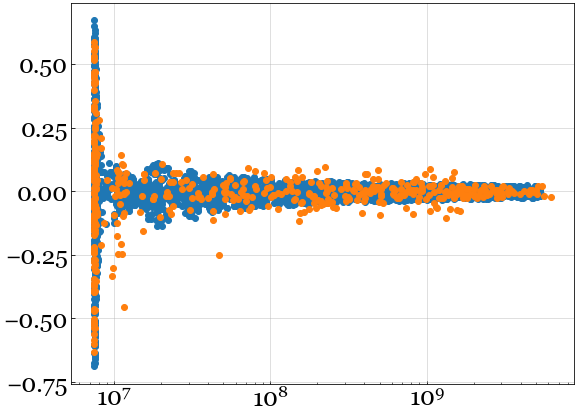

In [6]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.semilogx(t_m_da, chi_eff_da, ls='', marker='.')
ax.semilogx(t_m_sa, chi_eff_sa, ls='', marker='.')

2555


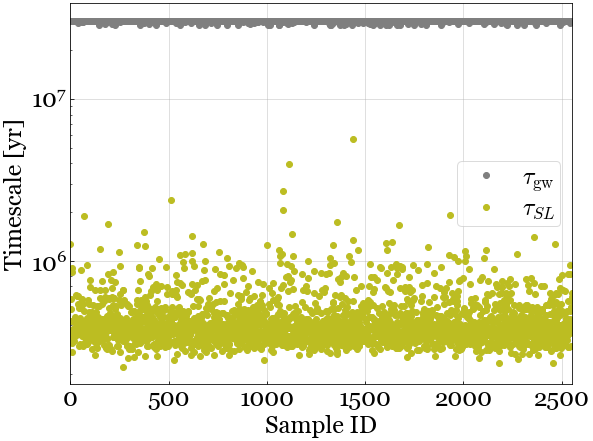

In [21]:
idx_da=(chi_eff_da>-0.1) & (chi_eff_da<0.1) & (t_m_da>0e7)
idx_sa=(chi_eff_sa>-0.1) & (chi_eff_sa<0.1) & (t_m_sa>0e7)
print(len(chi_eff_da[idx_da]))

nSamp = len(chi_eff_da[idx_da])

tau_600_gw = np.zeros(nSamp)
tau_600_pre = np.zeros(nSamp)

for i in range(nSamp):
    tau_600_gw[i] = get_inst_t_gw_from_a_orb(M1, M2, 600.*r_Mt, e_600_da[idx_da][i])
    
    par = np.array([M1, M2, S1, S2, chi_eff_da[idx_da][i]])
    tau_600_pre[i] = \
        get_tau_pre(J_600_da[idx_da][i], L_600_da[idx_da][i], e_600_da[idx_da][i], par, nPt=1000)
    
fig=plt.figure()
ax=fig.add_subplot(111)
ax.semilogy(np.arange(nSamp), tau_600_gw, color='tab:grey', ls='', marker='.', label=r'$\tau_{\rm gw}$')
ax.semilogy(np.arange(nSamp), tau_600_pre, color='tab:olive', ls='', marker='.', label=r'$\tau_{SL}$')
ax.set_ylabel(r'Timescale [yr]')
ax.set_xlabel(r'Sample ID')
ax.legend(loc='center right')
ax.set_xlim([0, nSamp])
plt.savefig(fig_dir+'timescale_600.pdf')

In [22]:
parConst = np.array([M1, M2, S1, S2])

# fig=plt.figure()
# ax=fig.add_subplot(111)
var_LK_da, pdf_LK_da \
    = pred_pdf_w_S(J_LK_da[idx_da], L_LK_da[idx_da], e_LK_da[idx_da], chi_eff_da[idx_da],\
                 parConst,\
                 nPtPDF=400, nPt=100, ax=ax, cut=0)

var_600_da, pdf_600_da \
    = pred_pdf_w_S(J_600_da[idx_da], L_600_da[idx_da], e_600_da[idx_da], chi_eff_da[idx_da],\
                 parConst,\
                 nPtPDF=400, nPt=100, ax=None, cut=0)

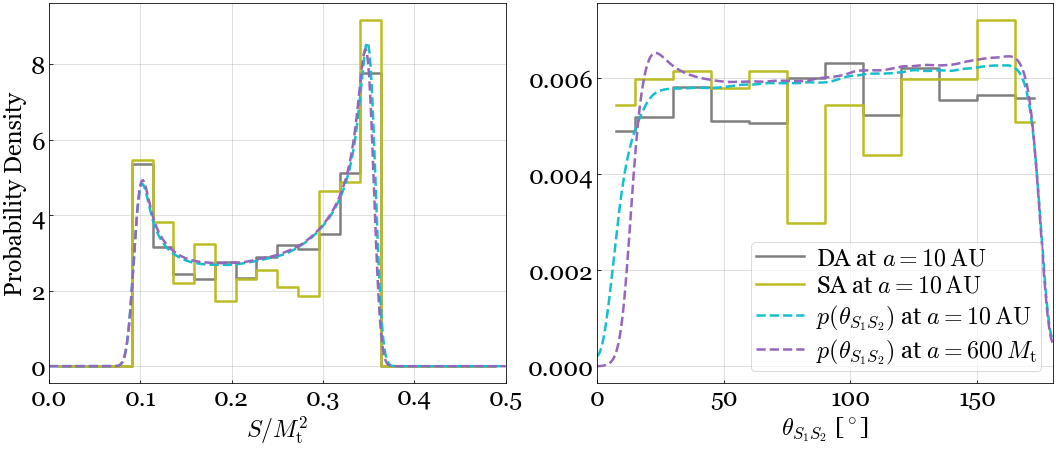

In [23]:
nbins=22
nbins_thSS=12
h_S_da, edges_S = np.histogram(S_LK_da[idx_da]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_S_sa, __ = np.histogram(S_LK_sa[idx_sa]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_thSS_da, edges_thSS = np.histogram(th_SS_da[idx_da]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)
h_thSS_sa, __ = np.histogram(th_SS_sa[idx_sa]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)

mid_S = (edges_S[1:] + edges_S[:-1])/2.
mid_thSS = (edges_thSS[1:] + edges_thSS[:-1])/2.
# mid = edges[:-1]

fig=plt.figure(figsize=(18, 7))
ax=fig.add_subplot(121)
ax.step(mid_S, h_S_da, where='mid', label=r'DA at $a = 10\,{\rm AU}$', color='tab:grey')
ax.step(mid_S, h_S_sa, where='mid', label=r'SA at $a = 10\,{\rm AU}$', color='tab:olive')
ax.plot(var_LK_da[0, :], g_filt(pdf_LK_da[0, :], 5), ls='--', label=r'$p(S)$ at $a = 10\,{\rm AU}$', color='tab:cyan')
ax.plot(var_600_da[0, :], g_filt(pdf_600_da[0, :], 5), ls='--', label=r'$p(S)$ at $a = 600\,M_{\rm t}$', color='tab:purple')
ax.set_xlim([0, 0.5])

# ax.plot(S_LK_v/S_Mt, 1./prob_S_LK_med_v/10., label=r'$\propto |{\rm d}S/{\rm d}t|/S\,|_{\overline{J}, \overline{L}}$')
# ax.legend()
ax.set_xlabel(r'$S/M_{\rm t}^2$')
ax.set_ylabel(r'Probability Density')

ax=fig.add_subplot(122)
ax.step(mid_thSS, h_thSS_da, where='mid', label=r'DA at $a = 10\,{\rm AU}$', color='tab:grey')
ax.step(mid_thSS, h_thSS_sa, where='mid', label=r'SA at $a = 10\,{\rm AU}$', color='tab:olive')
ax.plot(var_LK_da[-1, :], g_filt(pdf_LK_da[-1, :], 5), ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 10\,{\rm AU}$', color='tab:cyan')
ax.plot(var_600_da[-1, :], g_filt(pdf_600_da[-1, :], 5), ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 600\,M_{\rm t}$', color='tab:purple')
ax.set_xlim([0., 180.])
ax.legend()
ax.set_xlabel(r'$\theta_{S_1S_2}$ [$^\circ$]')
# ax.set_ylabel(r'Probability Density')

plt.savefig(fig_dir + 'S_thSS_dist.pdf')

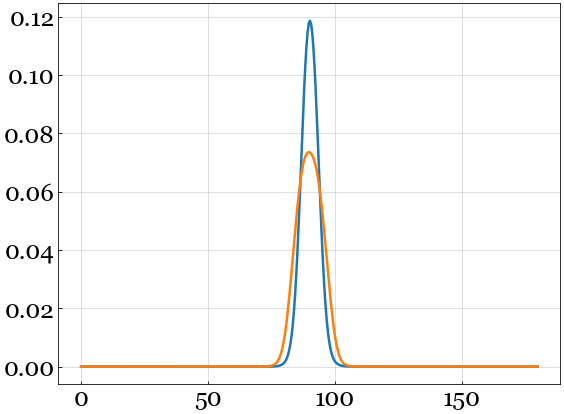

In [9]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(var_LK_da[1, :], g_filt(pdf_LK_da[1, :], 5))
ax.plot(var_600_da[1, :], g_filt(pdf_600_da[1, :], 5))

In [14]:
nSamp=len(chi_eff_da[idx_da])

nRel = 600
nPt = 100
S_600_da = np.zeros(nRel)
th_600_da = np.zeros([3, nRel])
for i in range(nRel):
    samp_id = stats.randint.rvs(0, nSamp-1)
    JJ, LL, ee = J_600_da[idx_da][samp_id], L_600_da[idx_da][samp_id], e_600_da[idx_da][samp_id]
    par_JL = np.array([M1, M2, S1, S2, chi_eff_da[idx_da][samp_id]])
    Sm, Sp = find_Smp(JJ, LL, ee, par_JL, nPt=nPt)
    SS = np.linspace(Sm, Sp, nPt)
    dSdt = np.zeros(nPt)
    for j in range(nPt):
        dSdt[j] = get_dSdt(JJ, LL, ee, SS[j], par_JL)
        
    pmf = 1./np.abs(dSdt)
    # hack the boundaries using extrapolation
    pmf[0]  = 2*pmf[1]-pmf[2] + 0.5*(pmf[3]+pmf[1]-2.*pmf[2]) 
    pmf[-1] = 2*pmf[-2]-pmf[-3] + 0.5*(pmf[-4]+pmf[-2]-2.*pmf[-3]) 

    pdf_S = pmf/integ.trapz(pmf, SS/S_Mt)
    # smooth the curve
    pdf_S = g_filt(pdf_S, np.int(np.round(nPt/20)))
    pdf_S = pdf_S/integ.trapz(pdf_S, SS/S_Mt)
    
    pdf_S_func = interp.interp1d(SS/S_Mt, pdf_S, bounds_error=False, fill_value=0)

    class S_pdf_class(stats.rv_continuous):
        def _pdf(self,SS):
            pdf = pdf_S_func(SS)
            return pdf
    SS = S_pdf_class(a=Sm/S_Mt, b=Sp/S_Mt, xtol=1.e-10).rvs() * S_Mt
    S_600_da[i] = SS
    
    th_1, th_2, th_12, __ = get_angles(JJ, LL, SS, ee, par_JL)
    th_600_da[0, i], th_600_da[1, i], th_600_da[2, i] \
        = th_1, th_2, th_12

/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1686: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in arccos
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: inv

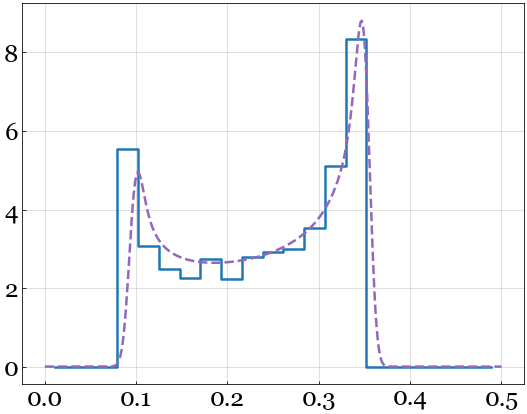

In [15]:
nbins=22
h_S_600_da, __ = np.histogram(S_600_da/S_Mt, bins=nbins, range=(0., 0.5), density=True)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.step(mid_S, h_S_da)
ax.plot(var_600_da[0, :], g_filt(pdf_600_da[0, :], 5), \
        color='tab:purple', ls='--', label=r'$p(S)$ at $a = 600\,M_{\rm t}$')

## Distribution at the end of LK; random initial spin orientation

In [4]:
data_dir_da='run_LK2merger/data/rand_init_spin_ang/DA/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/' 
data_dir_sa='run_LK2merger/data/rand_init_spin_ang/SA/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/'

fig_dir = '/home/hang.yu/public_html/astro/LK_evol/LK2merger/rand_init_spin_ang/dist/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

data_init_da =np.zeros([0, 13])
data_LK_da = np.zeros([0, 15])
data_600_da = np.zeros([0, 10])

data_init_sa =np.zeros([0, 13])
data_LK_sa = np.zeros([0, 15])
data_600_sa = np.zeros([0, 10])

nFile=10
for i in range(10):
    if os.path.exists(data_dir_da + 'id_%i_init_cond.txt'%i):
        data_init_da_ = np.loadtxt(data_dir_da + 'id_%i_init_cond.txt'%i)
        data_init_da = np.vstack([data_init_da, data_init_da_]) 
    
    if os.path.exists(data_dir_da + 'id_%i_LK_cond.txt'%i):
        data_LK_da_ = np.loadtxt(data_dir_da + 'id_%i_LK_cond.txt'%i)
        data_LK_da = np.vstack([data_LK_da, data_LK_da_])
        
    if os.path.exists(data_dir_da + 'id_%i_r_600_cond.txt'%i):
        data_600_da_ = np.loadtxt(data_dir_da + 'id_%i_r_600_cond.txt'%i)
        data_600_da = np.vstack([data_600_da, data_600_da_])
        
    if os.path.exists(data_dir_sa + 'id_%i_init_cond.txt'%i):
        data_init_sa_ = np.loadtxt(data_dir_sa + 'id_%i_init_cond.txt'%i)
        data_init_sa = np.vstack([data_init_sa, data_init_sa_]) 
    
    if os.path.exists(data_dir_sa + 'id_%i_LK_cond.txt'%i):
        data_LK_sa_ = np.loadtxt(data_dir_sa + 'id_%i_LK_cond.txt'%i)
        data_LK_sa = np.vstack([data_LK_sa, data_LK_sa_])
        
    if os.path.exists(data_dir_sa + 'id_%i_r_600_cond.txt'%i):
        data_600_sa_ = np.loadtxt(data_dir_sa + 'id_%i_r_600_cond.txt'%i)
        data_600_sa = np.vstack([data_600_sa, data_600_sa_])

In [5]:
M1, M2 = data_init_da[0, 0]*Ms, data_init_da[0, 1]*Ms
chi1, chi2= data_init_da[0, 2], data_init_da[0, 3]
S1, S2 = chi1*G*M1**2./c, chi2*G*M2**2./c

Mt=M1+M2
mu=M1*M2/Mt
r_Mt = G*(M1+M2)/c**2.
S_Mt = G*(M1+M2)**2./c
print(Mt/Ms, chi1, chi2)

a_LK = 10.*AU

# DA
chi_eff_init_da = data_init_da[:, 4]
I_S1_0_da = data_init_da[:, 6]
I_S2_0_da = data_init_da[:, 8]

chi_eff_da = data_LK_da[:, 4]
e_LK_da = 1.-data_LK_da[:, 6]
t_m_da = data_LK_da[:, 8]
J_LK_da = data_LK_da[:, 9]*S_Mt
L_LK_da = data_LK_da[:, 10]*S_Mt
S_LK_da = data_LK_da[:, 11]*S_Mt
th_S1L_da = data_LK_da[:, 12]
th_S2L_da = data_LK_da[:, 13]
th_SS_da = data_LK_da[:, 14]

J_600_da = data_600_da[:, 5]*S_Mt
L_600_da = data_600_da[:, 6]*S_Mt
e_600_da = data_600_da[:, 7]

# SA
chi_eff_init_sa = data_init_sa[:, 4]
I_S1_0_sa = data_init_sa[:, 6]
I_S2_0_sa = data_init_sa[:, 8]

chi_eff_sa = data_LK_sa[:, 4]
e_LK_sa = data_LK_sa[:, 6]
t_m_sa = data_LK_sa[:, 8]
J_LK_sa = data_LK_sa[:, 9]*S_Mt
L_LK_sa = data_LK_sa[:, 10]*S_Mt
S_LK_sa = data_LK_sa[:, 11]*S_Mt
th_S1L_sa = data_LK_sa[:, 12]
th_S2L_sa = data_LK_sa[:, 13]
th_SS_sa = data_LK_sa[:, 14]

J_600_sa = data_600_sa[:, 5]*S_Mt
L_600_sa = data_600_sa[:, 6]*S_Mt
e_600_sa = data_600_sa[:, 7]

150.0 0.7 0.7


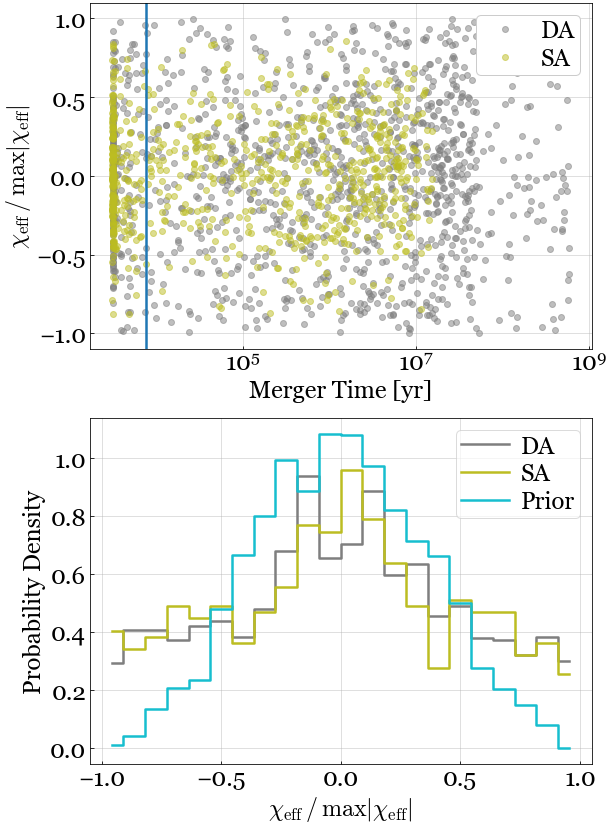

In [6]:
fig=plt.figure(figsize=(9, 14))
ax=fig.add_subplot(211)
ax.semilogx(t_m_da[:1200], chi_eff_da[:1200]/0.7, ls='', marker='.', alpha=0.5, label=r'DA', color='tab:grey')
# ax.semilogx(t_m_da, chi_eff_init_da, ls='', marker='.', alpha=0.5)
ax.semilogx(t_m_sa, chi_eff_init_sa/0.7, ls='', marker='.', alpha=0.5, label=r'SA', color='tab:olive')
ax.set_xlabel(r'Merger Time [yr]')
ax.set_ylabel(r'$\chi_{\rm eff}\,/\,\max |\chi_{\rm eff}|$')
ax.legend(loc='upper right', framealpha=1)
ax.axvline(7.5e3)


idx_da=t_m_da>7.5e3
idx_sa=t_m_sa>7.5e3
nbins=22

h_chie_da, edges = np.histogram(chi_eff_da[idx_da]/0.7, bins=nbins, range=(-1., 1.), density=True)
h_chie_sa, edges = np.histogram(chi_eff_sa[idx_sa]/0.7, bins=nbins, range=(-1., 1.), density=True)
h_chie0_da, __   = np.histogram(chi_eff_init_da[idx_da]/0.7, bins=nbins, range=(-1., 1.), density=True)

mid = (edges[:-1] + edges[1:])/2.

ax=fig.add_subplot(212)
ax.step(mid, h_chie_da, where='mid', label=r'DA', color='tab:grey')
ax.step(mid, h_chie_sa, where='mid', label=r'SA', color='tab:olive')
ax.step(mid, h_chie0_da, where='mid', label=r'Prior', color='tab:cyan')
ax.set_xlabel(r'$\chi_{\rm eff}\,/\,\max |\chi_{\rm eff}|$')
ax.set_ylabel(r'Probability Density')
ax.legend()
# plt.savefig(fig_dir + 'chi_eff_dist.pdf')


Text(0, 0.5, '$\\cos\\left[\\theta_{S_{1,2}L}\\right]$')

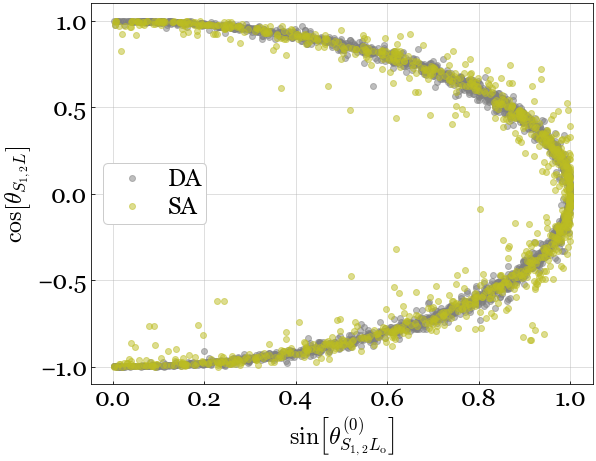

In [7]:
idx_da=t_m_da>5e3
idx_sa=t_m_sa>5e3

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(np.sin(I_S1_0_da[idx_da][:1200]), np.cos(th_S1L_da[idx_da][:1200]), \
        ls='', marker='.', alpha=0.5, color='tab:grey', label=r'DA')
ax.plot(np.sin(I_S2_0_da[idx_da][:1200]), np.cos(th_S2L_da[idx_da][:1200]), \
        ls='', marker='.', alpha=0.5, color='tab:grey')
ax.plot(np.sin(I_S1_0_sa[idx_sa]), np.cos(th_S1L_sa[idx_sa]), \
        ls='', marker='.', alpha=0.5, color='tab:olive', label=r'SA')
ax.plot(np.sin(I_S2_0_sa[idx_sa]), np.cos(th_S2L_sa[idx_sa]), \
        ls='', marker='.', alpha=0.5, color='tab:olive')
ax.legend(loc='center left', framealpha=1)

ax.set_xlabel(r'$\sin\left[\theta_{S_{1,2}L_{\rm o}}^{(0)}\right]$')
ax.set_ylabel(r'$\cos\left[\theta_{S_{1,2}L}\right]$')
# plt.savefig(fig_dir + 'cThSL_vs_sThS0.pdf')

In [8]:
idx_da = (np.abs(chi_eff_da)<0.1) #& (t_m_da>5.e3)
idx_sa = (np.abs(chi_eff_sa)<0.1) #& (t_m_sa>5.e3)
print(len(chi_eff_da[idx_da]))

parConst = np.array([M1, M2, S1, S2])
# fig=plt.figure()
# ax=fig.add_subplot(111)
var_LK_da, pdf_LK_da \
    = pred_pdf_w_S(J_LK_da[idx_da], L_LK_da[idx_da], e_LK_da[idx_da], chi_eff_da[idx_da],\
                 parConst,\
                 nPtPDF=400, nPt=100, ax=ax, cut=0)

var_600_da, pdf_600_da \
    = pred_pdf_w_S(J_600_da[idx_da], L_600_da[idx_da], e_600_da[idx_da], chi_eff_da[idx_da],\
                 parConst,\
                 nPtPDF=400, nPt=100, ax=None, cut=0)

571


Text(0.5, 0, '$\\theta_{S_1S_2}$ [$^\\circ$]')

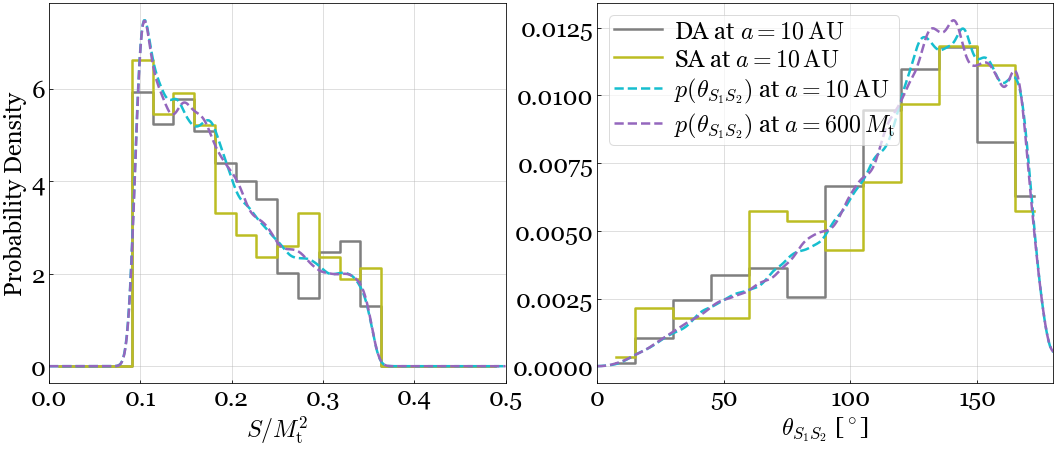

In [9]:
nbins=22
nbins_thSS=12
h_S_da, edges_S = np.histogram(S_LK_da[idx_da]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_S_sa, __ = np.histogram(S_LK_sa[idx_sa]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_thSS_da, edges_thSS = np.histogram(th_SS_da[idx_da]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)
h_thSS_sa, __ = np.histogram(th_SS_sa[idx_sa]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)

mid_S = (edges_S[1:] + edges_S[:-1])/2.
mid_thSS = (edges_thSS[1:] + edges_thSS[:-1])/2.
# mid = edges[:-1]

fig=plt.figure(figsize=(18, 7))
ax=fig.add_subplot(121)
ax.step(mid_S, h_S_da, where='mid', label=r'DA at $a = 10\,{\rm AU}$', color='tab:grey')
ax.step(mid_S, h_S_sa, where='mid', label=r'SA at $a = 10\,{\rm AU}$', color='tab:olive')
ax.plot(var_LK_da[0, :], g_filt(pdf_LK_da[0, :], 5), ls='--', label=r'$p(S)$ at $a = 10\,{\rm AU}$', color='tab:cyan')
ax.plot(var_600_da[0, :], g_filt(pdf_600_da[0, :], 5), ls='--', label=r'$p(S)$ at $a = 600\,M_{\rm t}$', color='tab:purple')
ax.set_xlim([0, 0.5])

# ax.plot(S_LK_v/S_Mt, 1./prob_S_LK_med_v/10., label=r'$\propto |{\rm d}S/{\rm d}t|/S\,|_{\overline{J}, \overline{L}}$')
# ax.legend()
ax.set_xlabel(r'$S/M_{\rm t}^2$')
ax.set_ylabel(r'Probability Density')

ax=fig.add_subplot(122)
ax.step(mid_thSS, h_thSS_da, where='mid', label=r'DA at $a = 10\,{\rm AU}$', color='tab:grey')
ax.step(mid_thSS, h_thSS_sa, where='mid', label=r'SA at $a = 10\,{\rm AU}$', color='tab:olive')
ax.plot(var_LK_da[-1, :], g_filt(pdf_LK_da[-1, :], 5), ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 10\,{\rm AU}$', color='tab:cyan')
ax.plot(var_600_da[-1, :], g_filt(pdf_600_da[-1, :], 5), ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 600\,M_{\rm t}$', color='tab:purple')
ax.set_xlim([0., 180.])
ax.legend()
ax.set_xlabel(r'$\theta_{S_1S_2}$ [$^\circ$]')
# ax.set_ylabel(r'Probability Density')

# plt.savefig(fig_dir + 'chi_eff_0_S_thSS_dist.pdf')

In [35]:
idx_da = (chi_eff_da<0.4) & (chi_eff_da>0.3) #& (t_m_da>2.e7)
print(len(chi_eff_da[idx_da]))

parConst = np.array([M1, M2, S1, S2])
# fig=plt.figure()
# ax=fig.add_subplot(111)
var_LK_da, pdf_LK_da \
    = pred_pdf_w_S(J_LK_da[idx_da], L_LK_da[idx_da], e_LK_da[idx_da], chi_eff_da[idx_da],\
                 parConst,\
                 nPtPDF=400, nPt=100, ax=ax, cut=0)

var_600_da, pdf_600_da \
    = pred_pdf_w_S(J_600_da[idx_da], L_600_da[idx_da], e_600_da[idx_da], chi_eff_da[idx_da],\
                 parConst,\
                 nPtPDF=400, nPt=100, ax=None, cut=0)

549


Text(0.5, 0, '$\\theta_{S_1S_2}$ [$^\\circ$]')

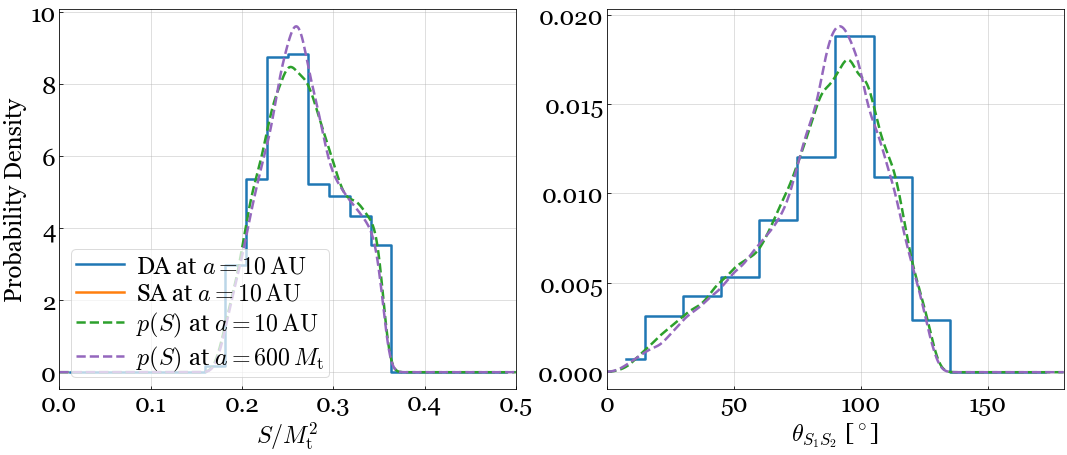

In [39]:
nbins=22
nbins_thSS=12
h_S_da, edges_S = np.histogram(S_LK_da[idx_da]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_S_sa, __ = np.histogram(S_LK_sa[idx_sa]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_thSS_da, edges_thSS = np.histogram(th_SS_da[idx_da]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)
h_thSS_sa, __ = np.histogram(th_SS_sa[idx_sa]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)

mid_S = (edges_S[1:] + edges_S[:-1])/2.
mid_thSS = (edges_thSS[1:] + edges_thSS[:-1])/2.
# mid = edges[:-1]

fig=plt.figure(figsize=(18, 7))
ax=fig.add_subplot(121)
ax.step(mid_S, h_S_da, where='mid', label=r'DA at $a = 10\,{\rm AU}$')
ax.step(mid_S, h_S_sa, where='mid', label=r'SA at $a = 10\,{\rm AU}$')
ax.plot(var_LK_da[0, :], g_filt(pdf_LK_da[0, :], 5), ls='--', label=r'$p(S)$ at $a = 10\,{\rm AU}$')
ax.plot(var_600_da[0, :], g_filt(pdf_600_da[0, :], 5), color='tab:purple', ls='--', label=r'$p(S)$ at $a = 600\,M_{\rm t}$')
ax.set_xlim([0, 0.5])

# ax.plot(S_LK_v/S_Mt, 1./prob_S_LK_med_v/10., label=r'$\propto |{\rm d}S/{\rm d}t|/S\,|_{\overline{J}, \overline{L}}$')
ax.legend(loc='lower left')
ax.set_xlabel(r'$S/M_{\rm t}^2$')
ax.set_ylabel(r'Probability Density')

ax=fig.add_subplot(122)
ax.step(mid_thSS, h_thSS_da, where='mid', label=r'DA at $a = 10\,{\rm AU}$')
ax.step(mid_thSS, h_thSS_sa, where='mid', label=r'SA at $a = 10\,{\rm AU}$')
ax.plot(var_LK_da[-1, :], g_filt(pdf_LK_da[-1, :], 5), ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 10\,{\rm AU}$')
ax.plot(var_600_da[-1, :], g_filt(pdf_600_da[-1, :], 5), color='tab:purple', ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 600\,M_{\rm t}$')
ax.set_xlim([0., 180.])
# ax.legend()
ax.set_xlabel(r'$\theta_{S_1S_2}$ [$^\circ$]')
# ax.set_ylabel(r'Probability Density')

# plt.savefig(fig_dir + 'chi_eff_0_S_thSS_dist.pdf')

## Distribution at the merger from binary evolution

In [32]:
data_dir = 'run_LK2merger/data/fix_init_spin_ang/bin2merg/'
fig_dir_f = '/home/hang.yu/public_html/astro/LK_evol/LK2merger/fix_init_spin_ang/bin2merg/'

if not os.path.exists(fig_dir_f):
    os.makedirs(fig_dir_f)

data=np.zeros([0, 14])
nFile=10
for i in range(10):
    if os.path.exists(data_dir + 'id_%i_bin_evol.txt'%i):
        data_ = np.loadtxt(data_dir + 'id_0_bin_evol.txt') 
        data = np.vstack([data, data_])
        
M1, M2 = data[0, 0]*Ms, data[0, 1]*Ms
qq = M2/M1
Mt = (M1+M2) 
mu = M1 * M2/ Mt

r_Mt = G*Mt/c**2.
S_Mt = G*Mt**2./c
r_isco = 6.*r_Mt

chi1, chi2 = data[0, 2], data[0, 3]
S1, S2=chi1 * G*M1**2./c, chi2 * G*M2**2./c
print(chi1, chi2)
chi_eff_v_f=data[:, 4]

J_init_f, L_init_f, S_init_f = data[:, 5]*S_Mt, data[:, 6]*S_Mt, data[:, 7]*S_Mt
eff_init_f = L_init_f/(mu*np.sqrt(G*Mt*600.*r_Mt))
e_init_f = np.sqrt(1.-eff_init_f**2.)

J_v_f, L_v_f, S_v_f = data[:, 8]*S_Mt, data[:, 9]*S_Mt, data[:, 10]*S_Mt
th_S1L_f, th_S2L_f, th_SS_f = data[:, 11], data[:, 12], data[:, 13]

nSamp_f = len(J_v_f)
th_S1L_init_f, th_S2L_init_f, th_SS_init_f = np.zeros(nSamp_f), np.zeros(nSamp_f), np.zeros(nSamp_f)
dphi_init_f = np.zeros(nSamp_f)


omega_dS = 1.5 * G*(M2+mu/3.)/(c**2.*r_isco) * np.sqrt(G*Mt/r_isco**3.)
omega_dS_br = 0.5 * G*S2*(4.+3.*M1/M2)/(c**2. * r_isco**3.)
print(omega_dS, omega_dS_br, omega_dS_br/omega_dS)

for i in range(nSamp_f):
    par = np.array([M1, M2, S1, S2, chi_eff_v_f[i]])
    th_S1L_init_f[i], th_S2L_init_f[i], th_SS_init_f[i],  dphi_init_f[i]\
        = get_angles(J_init_f[i], L_init_f[i], e_init_f[i], S_init_f[i], par)

0.7 0.7
11.860913133900631 3.2628265466299817 0.27509067049013575


In [31]:
data_dir = 'run_LK2merger/data/rand_init_spin_ang/bin2merg/chi_eff_0/'
fig_dir_r = '/home/hang.yu/public_html/astro/LK_evol/LK2merger/rand_init_spin_ang/bin2merg/chi_eff_0/'

if not os.path.exists(fig_dir_r):
    os.makedirs(fig_dir_r)

data=np.zeros([0, 14])
nFile=10
for i in range(10):
    if os.path.exists(data_dir + 'id_%i_bin_evol.txt'%i):
        data_ = np.loadtxt(data_dir + 'id_0_bin_evol.txt') 
        data = np.vstack([data, data_])
        
M1, M2 = data[0, 0]*Ms, data[0, 1]*Ms
qq = M2/M1
Mt = (M1+M2) 
mu = M1 * M2/ Mt

r_Mt = G*Mt/c**2.
S_Mt = G*Mt**2./c
r_isco = 6.*r_Mt

chi1, chi2 = data[0, 2], data[0, 3]
S1, S2=chi1 * G*M1**2./c, chi2 * G*M2**2./c
print(chi1, chi2)
chi_eff_v_r=data[:, 4]

J_init_r, L_init_r, S_init_r = data[:, 5]*S_Mt, data[:, 6]*S_Mt, data[:, 7]*S_Mt
eff_init_r = L_init_r/(mu*np.sqrt(G*Mt*600.*r_Mt))
e_init_r = np.sqrt(1.-eff_init_r**2.)

J_v_r, L_v_r, S_v_r = data[:, 8]*S_Mt, data[:, 9]*S_Mt, data[:, 10]*S_Mt
th_S1L_r, th_S2L_r, th_SS_r = data[:, 11], data[:, 12], data[:, 13]

nSamp_r = len(J_v_r)
th_S1L_init_r, th_S2L_init_r, th_SS_init_r = np.zeros(nSamp_r), np.zeros(nSamp_r), np.zeros(nSamp_r)
dphi_init_r = np.zeros(nSamp_r)


omega_dS = 1.5 * G*(M2+mu/3.)/(c**2.*r_isco) * np.sqrt(G*Mt/r_isco**3.)
omega_LT = 0.5 * G*S2/(c**2. * r_isco**3.)
print(omega_dS, omega_LT, omega_LT/omega_dS)

for i in range(nSamp_r):
    par = np.array([M1, M2, S1, S2, chi_eff_v_r[i]])
    th_S1L_init_r[i], th_S2L_init_r[i], th_SS_init_r[i],  dphi_init_r[i]\
        = get_angles(J_init_r[i], L_init_r[i], e_init_r[i], S_init_r[i], par)
    

0.7 0.7
11.860913133900631 0.4118130592833957 0.034720181712347226


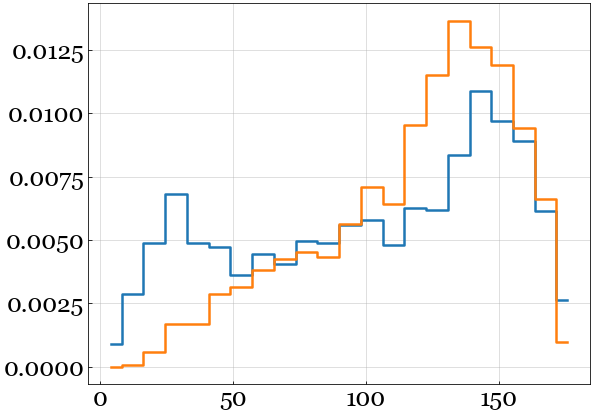

In [9]:
h_SS, edges = np.histogram(th_SS_r*180./np.pi, bins=22, range=(0., 180.), density=True)
h_SS0, edges = np.histogram(th_SS_init_r*180./np.pi, bins=22, range=(0., 180.), density=True)
mid = (edges[1:] + edges[:-1])/2.
fig=plt.figure()
ax=fig.add_subplot(111)
ax.step(mid, h_SS, where='mid')
ax.step(mid, h_SS0, where='mid')

/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in arccos
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in greater


500 498


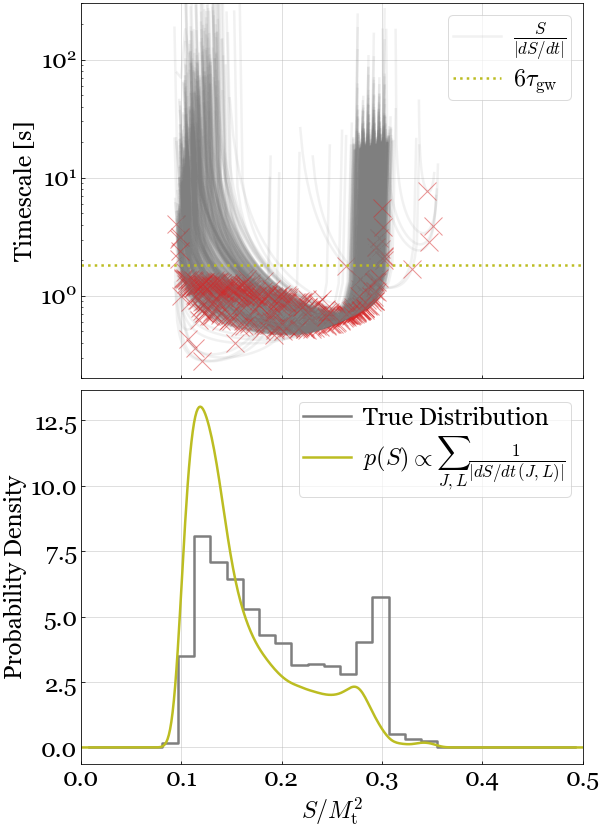

In [11]:
nPt = 50
nPtPDF = 400
nSamp_f = len(J_v_f)

nSamp_f = 500
fig=plt.figure(figsize=(9, 14))
ax=fig.add_subplot(211)

tau_gw = get_inst_t_gw_from_a_orb(M1, M2, 6*r_Mt, 0)

S_pdf_f = np.linspace(0, 0.5, nPtPDF) # in S_Mt
pdf_S_f = np.zeros(nPtPDF)
pdf_S_f_no_cut = np.zeros(nPtPDF)

tau_gw_cut=6.
cnt = 0
for i in range(nSamp_f):
    JJ, LL=J_v_f[i], L_v_f[i]
    ee = 0.

    chi_eff = chi_eff_v_f[i]
#     print(JJ/S_Mt, LL/S_Mt)
    par = np.array([M1, M2, S1, S2, chi_eff])
    
    try:
        S_m, S_p = find_Smp(JJ, LL, ee, par, nPt=nPt)
        SS = np.linspace(S_m, S_p, nPt)
        dSdt = np.zeros(nPt)
    
        tau = get_tau_pre(JJ, LL, ee, par, nPt=nPt)
        for j in range(nPt):
            dSdt[j] = get_dSdt(JJ, LL, ee, SS[j], par)
            
        dSdt_ref = get_dSdt(JJ, LL, ee, S_v_f[i], par)
    
        if cnt==0:
            ax.semilogy(SS/S_Mt, np.abs(SS/dSdt), color='tab:grey', alpha=0.1, label=r'$\frac{S}{|dS/dt|}$')
        else:
            ax.semilogy(SS/S_Mt, np.abs(SS/dSdt), color='tab:grey', alpha=0.1)
        ax.semilogy([S_v_f[i]/S_Mt], [np.abs(S_v_f[i]/dSdt_ref)], color='tab:red', ls='', marker='x', alpha=0.5, ms=18)
    
        pmf = 1/np.abs(dSdt)
        ### hack the boundaries using extrapolation
        pmf[0]  = 2*pmf[1]-pmf[2] + 0.5*(pmf[3]+pmf[1]-2.*pmf[2]) 
        pmf[-1] = 2*pmf[-2]-pmf[-3] + 0.5*(pmf[-4]+pmf[-2]-2.*pmf[-3]) 
        
        # no cut
        pdf_S_ = pmf/integ.trapz(pmf, SS/S_Mt)
        pdf_vs_S = interp.interp1d(SS/S_Mt, pdf_S_, bounds_error=False, fill_value=0)
    
        pdf_S_ = pdf_vs_S(S_pdf_f)
        pdf_S_f_no_cut += pdf_S_

        # cut based on tau_gw
        idx = np.abs(SS/dSdt) > (tau_gw_cut*tau_gw)
#         pmf[idx] *= 0.
        pmf[idx] = np.ones_like(pmf[idx]) * tau_gw/SS[idx]
    
        pdf_S_ = pmf/integ.trapz(pmf, SS/S_Mt)
        pdf_vs_S = interp.interp1d(SS/S_Mt, pdf_S_, bounds_error=False, fill_value=0)
    
        pdf_S_ = pdf_vs_S(S_pdf_f)
        pdf_S_f += pdf_S_
        cnt += 1
        
    except ValueError:
        continue

pdf_S_f_no_cut/=cnt
pdf_S_f/=cnt

print(nSamp_f, cnt)
    
ax.axhline(tau_gw_cut*tau_gw, ls=':', color='tab:olive', label=r'$%.0f\tau_{\rm gw}$'%tau_gw_cut)
ax.set_xlim([0., 0.5])
ax.set_ylim([0.2, 3.e2])
ax.set_ylabel(r'Timescale [s]')
ax.legend(loc='upper right')
ax.xaxis.set_ticklabels([])

h_SS, edges = np.histogram(S_v_f/S_Mt, bins=31, range=(0, 0.5), density=True)
mid = (edges[1:] + edges[:-1])/2.
ax=fig.add_subplot(212)
ax.step(mid, h_SS, where='mid', color='tab:grey', label=r'True Distribution')
ax.plot(S_pdf_f, g_filt(pdf_S_f_no_cut, 5), color='tab:olive', label=r'$p(S) \propto \sum_{J, L} \frac{1}{|dS/dt\,(J, L)|}$')
ax.legend(loc='upper right')
ax.set_xlim([0., 0.5])
ax.set_ylabel(r'Probability Density')
ax.set_xlabel(r'$S/M_{\rm t}^2$')
plt.subplots_adjust(hspace=0.03)
# plt.savefig(fig_dir_f + 'S_dist_isco.pdf')

/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in arccos
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in greater
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in arccos


700 625


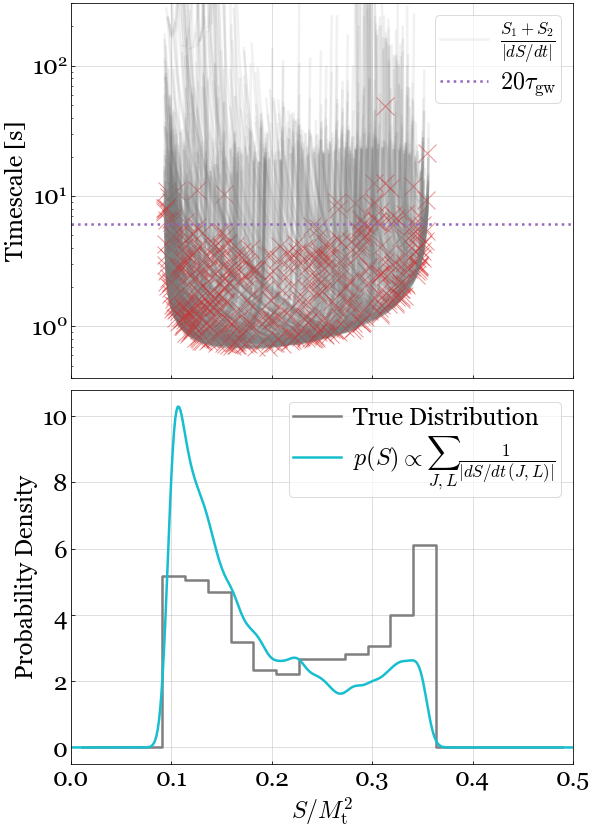

In [38]:
nPt = 50
nPtPDF = 400
nSamp_r = len(J_v_r)

nSamp_r = 700
fig=plt.figure(figsize=(9, 14))
ax=fig.add_subplot(211)

tau_gw = get_inst_t_gw_from_a_orb(M1, M2, 6*r_Mt, 0)

S_pdf_r = np.linspace(0, 0.5, nPtPDF) # in S_Mt
pdf_S_r = np.zeros(nPtPDF)
pdf_S_r_no_cut = np.zeros(nPtPDF)

tau_gw_cut=20.
cnt = 0
for i in range(nSamp_r):
    JJ, LL=J_v_r[i], L_v_r[i]
    ee = 0.

    chi_eff = chi_eff_v_r[i]
#     print(JJ/S_Mt, LL/S_Mt)
    par = np.array([M1, M2, S1, S2, chi_eff])
    
    try:
        S_m, S_p = find_Smp(JJ, LL, ee, par, nPt=nPt)
        SS = np.linspace(S_m, S_p, nPt)
        dSdt = np.zeros(nPt)
    
        tau = get_tau_pre(JJ, LL, ee, par, nPt=nPt)
        for j in range(nPt):
            dSdt[j] = get_dSdt(JJ, LL, ee, SS[j], par)
            
        dSdt_ref = get_dSdt(JJ, LL, ee, S_v_r[i], par)
    
        if cnt==0:
            ax.semilogy(SS/S_Mt, np.abs((S1+S2)/dSdt), color='tab:grey', alpha=0.1, \
                        label=r'${\left(S_1+S_2\right)}/{|dS/dt|}$')
        else:
            ax.semilogy(SS/S_Mt, np.abs((S1+S2)/dSdt), color='tab:grey', alpha=0.1)
        ax.semilogy([S_v_r[i]/S_Mt], [np.abs((S1+S2)/dSdt_ref)], color='tab:red', ls='', marker='x', alpha=0.5, ms=18)
    
        pmf = 1/np.abs(dSdt)
        ### hack the boundaries using extrapolation
        pmf[0]  = 2*pmf[1]-pmf[2] + 0.5*(pmf[3]+pmf[1]-2.*pmf[2]) 
        pmf[-1] = 2*pmf[-2]-pmf[-3] + 0.5*(pmf[-4]+pmf[-2]-2.*pmf[-3]) 
        
        # no cut
        pdf_S_ = pmf/integ.trapz(pmf, SS/S_Mt)
        pdf_vs_S = interp.interp1d(SS/S_Mt, pdf_S_, bounds_error=False, fill_value=0)
    
        pdf_S_ = pdf_vs_S(S_pdf_r)
        pdf_S_r_no_cut += pdf_S_

        # cut based on tau_gw
        idx = np.abs((S1+S2)/dSdt) > (tau_gw_cut*tau_gw)
        pmf[idx] *= 0.
        pmf[idx] = np.ones_like(pmf[idx]) * tau_gw_cut*tau_gw/(S1+S2)
    
        pdf_S_ = pmf/integ.trapz(pmf, SS/S_Mt)
        pdf_vs_S = interp.interp1d(SS/S_Mt, pdf_S_, bounds_error=False, fill_value=0)
    
        pdf_S_ = pdf_vs_S(S_pdf_r)
        pdf_S_r += pdf_S_
        cnt += 1
        
    except ValueError:
        continue

pdf_S_r_no_cut/=cnt
pdf_S_r/=cnt

print(nSamp_r, cnt)
    
ax.axhline(tau_gw_cut*tau_gw, ls=':', color='tab:purple', label=r'$%.0f\tau_{\rm gw}$'%tau_gw_cut)
ax.set_xlim([0., 0.5])
ax.set_ylim([0.4, 3.e2])
ax.set_ylabel(r'Timescale [s]')
ax.legend(loc='upper right')
ax.xaxis.set_ticklabels([])

h_SS, edges = np.histogram(S_v_r/S_Mt, bins=22, range=(0, 0.5), density=True)
mid = (edges[1:] + edges[:-1])/2.
ax=fig.add_subplot(212)
ax.step(mid, h_SS, where='mid', color='tab:grey', label=r'True Distribution')
ax.plot(S_pdf_r, g_filt(pdf_S_r_no_cut, 5), color='tab:cyan', label=r'$p(S) \propto \sum_{J, L} \frac{1}{|dS/dt\,(J, L)|}$')
# ax.plot(S_pdf_r, g_filt(pdf_S_r, 5), color='tab:cyan', label=r'$p(S) \propto \sum_{J, L} \frac{1}{|dS/dt\,(J, L)|}$')
ax.legend(loc='upper right')
ax.set_xlim([0., 0.5])
ax.set_ylabel(r'Probability Density')
ax.set_xlabel(r'$S/M_{\rm t}^2$')
plt.subplots_adjust(hspace=0.03)
plt.savefig(fig_dir_r + 'S_dist_isco.pdf')

(6000, 3) (6009, 3)


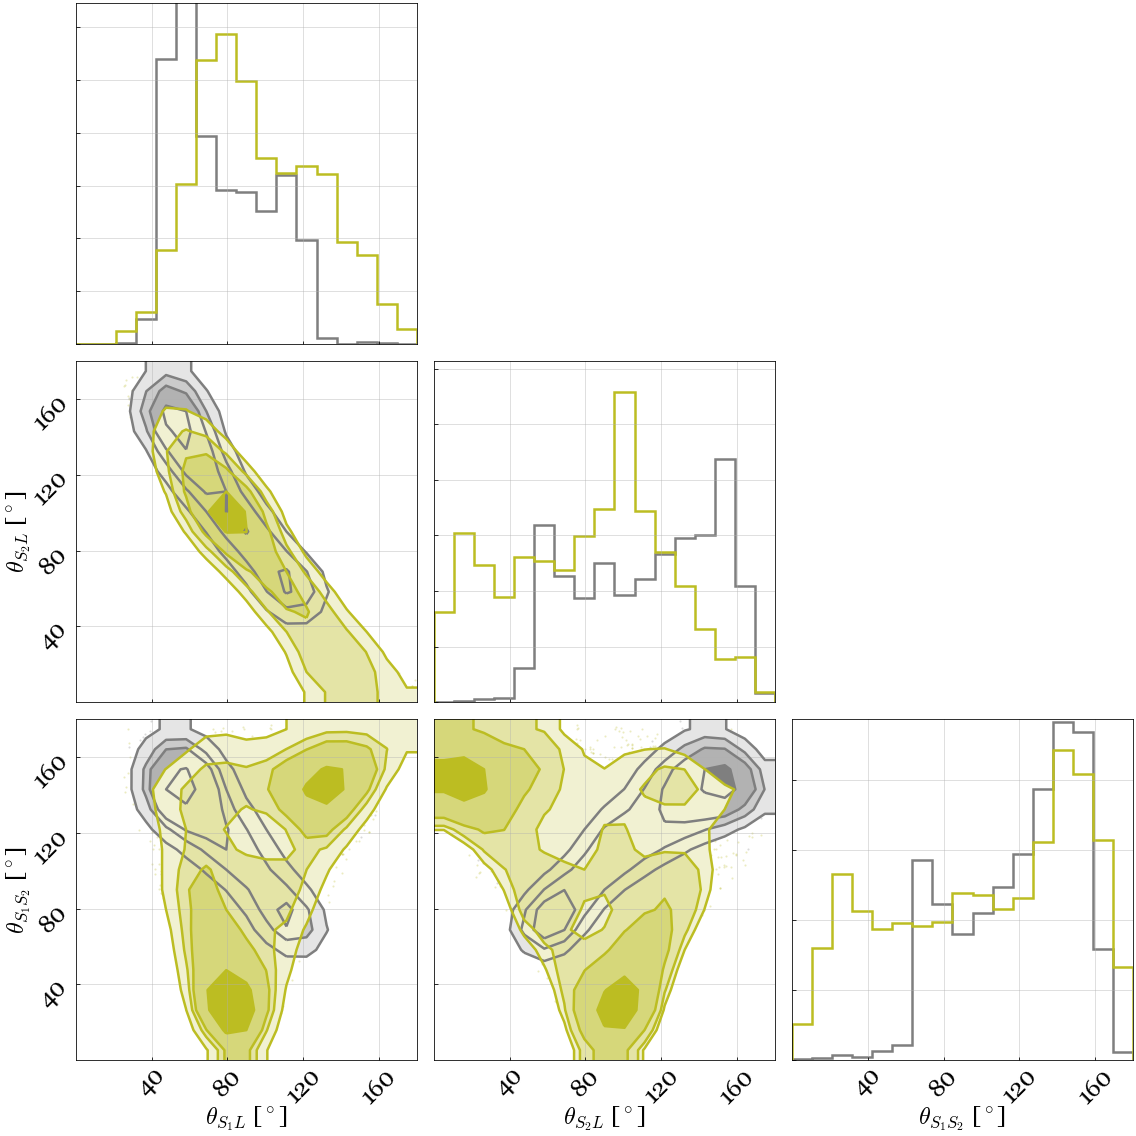

In [44]:
th_dist_f = np.vstack([th_S1L_f*180./np.pi, th_S2L_f*180./np.pi, th_SS_f*180./np.pi]).T
th_dist_r = np.vstack([th_S1L_r*180./np.pi, th_S2L_r*180./np.pi, th_SS_r*180./np.pi]).T
print(th_dist_f.shape, th_dist_r.shape)

nSamp_f = th_dist_f.shape[0]
nSamp_r = th_dist_r.shape[0]

fig, axes=plt.subplots(3, 3, figsize=(18, 18))
fig = corner.corner(th_dist_f, fig=fig, bins=17,
        color='tab:grey', 
        labels_kwargs={'pad':-30, 'labelpad':-30},
        range=[(0, 180), (0, 180), (0, 180)], 
        show_titles=False, plot_contours=True, fill_contours=True,
        smooth=1, 
        hist_kwargs={'lw':2.5})

fig=corner.corner(th_dist_r, fig=fig, bins=17, 
        color='tab:olive', ls=2.5, weights=np.ones(nSamp_r)*float(nSamp_f)/nSamp_r*1.33, 
        labels_kwargs={'pad':-30, 'labelpad':-30},
        range=[(0, 180), (0, 180), (0, 180)], 
        show_titles=False, plot_contours=True, fill_contours=True,
        smooth=1, 
        hist_kwargs={'lw':2.5})

axes[1, 0].set_ylabel(r'$\theta_{S_2L}$ [$^\circ$]', labelpad=-4)
axes[2, 0].set_ylabel(r'$\theta_{S_1S_2}$ [$^\circ$]', labelpad=-4)
axes[2, 0].set_xlabel(r'$\theta_{S_1L}$ [$^\circ$]', labelpad=-4)
axes[2, 1].set_xlabel(r'$\theta_{S_2L}$ [$^\circ$]', labelpad=-4)
axes[2, 2].set_xlabel(r'$\theta_{S_1S_2}$ [$^\circ$]', labelpad=-4)
plt.savefig(fig_dir_r+'ang_dist_isco.pdf')

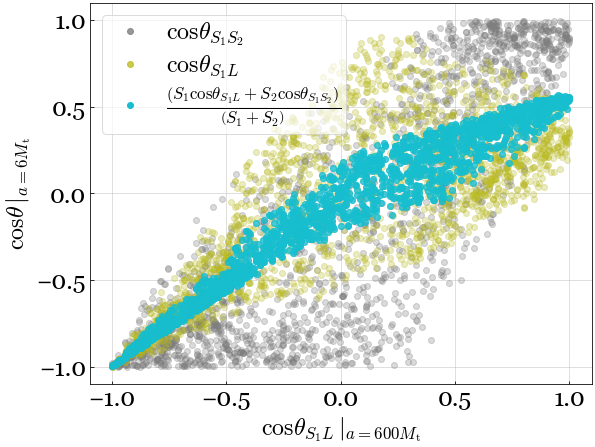

In [60]:
fig=plt.figure()
ax=fig.add_subplot(111)
# ax.plot((th_S1L_init)*180./np.pi, th_SS*180./np.pi, ls='', marker='.', alpha=0.3)
# ax.plot(th_S1L_init*180./np.pi, th_S1L*180./np.pi, ls='', marker='.', alpha=0.3)
# ax.plot(th_S1L_init*180./np.pi, (th_SS+(S1/S2)*th_S1L)/(1+S1/S2)*180./np.pi, ls='', marker='.', alpha=0.3)
# ax.plot(th_S1L_init*180./np.pi, (th_SS+th_S1L)/(1+1)*180./np.pi, ls='', marker='.', alpha=0.3)
# ax.plot(th_S2L_init*180./np.pi, (th_SS-th_S2L)*180./np.pi, ls='', marker='.', alpha=0.3)
# ax.set_xlim([0., 180.])
# ax.set_ylim([0., 180.])
# ax.plot([0., 180.], [0., 180.])

ax.plot(np.cos(th_S1L_init_r), np.cos(th_SS_r), ls='', marker='.', color='tab:grey', alpha=0.1)
ax.plot(np.cos(th_S1L_init_r), np.cos(th_S1L_r), ls='', marker='.', color='tab:olive', alpha=0.1)
# ax.plot(np.cos(th_S1L_init_f), (S2*np.cos(th_SS_f) + S1*np.cos(th_S1L_f))/(S1+S2), ls='', marker='.', alpha=0.1, color='tab:grey')
ax.plot(np.cos(th_S1L_init_r), (S2*np.cos(th_SS_r) + S1*np.cos(th_S1L_r))/(S1+S2), ls='', marker='.', alpha=0.4, color='tab:cyan')
# ax.plot([-1,1], [-1, 1])

ax.plot([], [], ls='', marker='.', color='tab:grey', alpha=0.8, \
       label=r'$\cos \theta_{S_1 S_2}$')
ax.plot([], [], ls='', marker='.', color='tab:olive', alpha=0.8, \
        label=r'$\cos \theta_{S_1 L}$')
ax.plot([], [], ls='', marker='.', alpha=1, color='tab:cyan', \
        label=r'$\frac{\left(S_1 \cos \theta_{S_1L} + S_2\cos \theta_{S_1S_2}\right)}{\left(S_1+S_2\right)}$')

ax.legend(loc='upper left')
ax.set_xlabel(r'$\cos \theta_{S_1 L}\,|_{a=600 M_{\rm t}}$')
ax.set_ylabel(r'$\cos \theta\,|_{a=6 M_{\rm t}}$')

# print(np.mean((S2*np.cos(th_SS) + S1*np.cos(th_S1L))/(S1+S2)), np.percentile((S2*np.cos(th_SS) + S1*np.cos(th_S1L))/(S1+S2), [15, 85]))
# print(np.mean((M2*np.cos(th_SS) + M1*np.cos(th_S1L))/(M1+M2)), np.percentile((M2*np.cos(th_SS) + M1*np.cos(th_S1L))/(M1+M2), [15, 85]))

plt.savefig(fig_dir_r+'fin_vs_init_dist.pdf')



150.0 0.7 0.7


Text(0, 0.5, '$\\chi$')

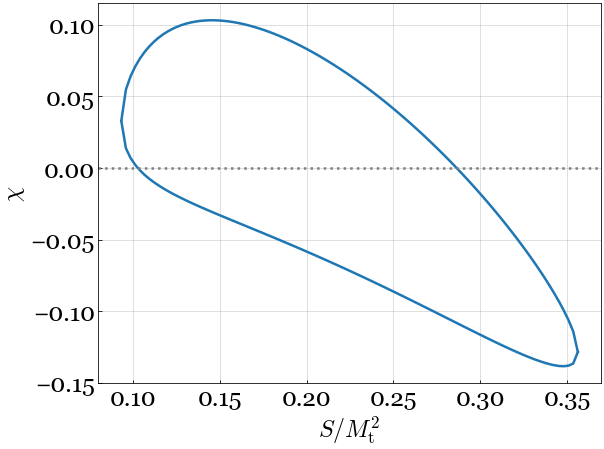

In [6]:
M1, M2 = 85*Ms, 65*Ms
chi1, chi2= 0.7, 0.7
S1, S2 = chi1*G*M1**2./c, chi2*G*M2**2./c
chi_eff=0

Mt=M1+M2
mu=M1*M2/Mt
r_Mt = G*(M1+M2)/c**2.
S_Mt = G*(M1+M2)**2./c
print(Mt/Ms, chi1, chi2)

JJ, LL, SS = \
    0.6403503521469661*S_Mt, 0.6014858139456225*S_Mt, 0.13796131432779857*S_Mt

nPt = 100
par = np.array([M1, M2, S1, S2, chi_eff])
S_m, S_p = find_Smp(JJ, LL, 0., par, nPt=nPt)
S_v = np.linspace(S_m, S_p, nPt)

S_plot, chi1_plot, chi2_plot = find_S_chi_contour(JJ, LL, 0., par, nPt=nPt)
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(S_plot/S_Mt, chi1_plot)
ax.plot(S_plot/S_Mt, chi2_plot, color='tab:blue')
ax.axhline(chi_eff, color='tab:grey', ls=':')
ax.set_xlabel(r'$S/M_{\rm t}^2$')
ax.set_ylabel(r'$\chi$')

Text(0, 0.5, 'Probability Density')

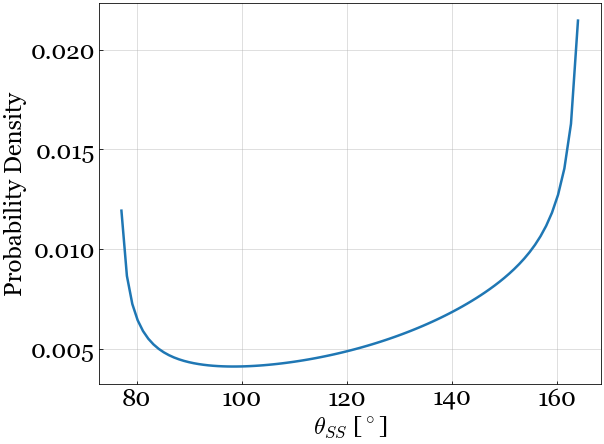

In [12]:
dSdt = np.zeros(nPt)
th1, th2, th12, dphi = np.zeros(nPt), np.zeros(nPt), np.zeros(nPt), np.zeros(nPt)
for i in range(nPt):
    dSdt[i] = get_dSdt(JJ, LL, 0, S_v[i], par)
    th1[i], th2[i], th12[i], dphi[i]=\
        get_angles(JJ, LL, 0, S_v[i], par)
    
tau_pre = get_tau_pre(JJ, LL, 0, par)

prob = np.abs(S_v/dSdt/tau_pre)
prob /= np.sum(prob)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(th12[1:-1]*180./np.pi, (prob/np.abs(np.gradient(th12*180./np.pi)))[1:-1])
ax.set_xlabel(r'$\theta_{SS}$ [$^\circ$]')
ax.set_ylabel(r'Probability Density')

Text(0, 0.5, 'Probability Density')

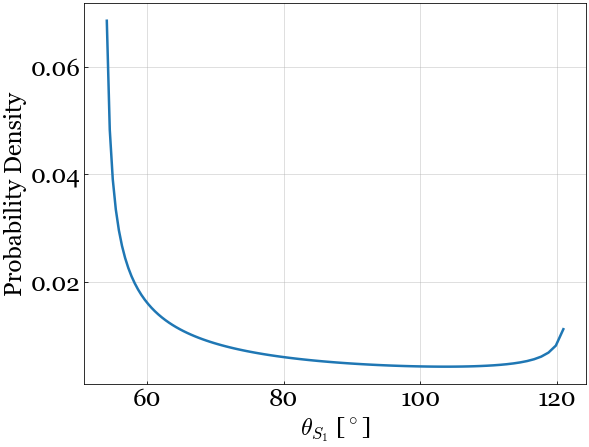

In [14]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(th1[1:-1]*180./np.pi, (prob/np.abs(np.gradient(th1*180./np.pi)))[1:-1])
ax.set_xlabel(r'$\theta_{S_1}$ [$^\circ$]')
ax.set_ylabel(r'Probability Density')

In [28]:
test = np.array([0, 1, 1./0.])
np.isnan(test)

ZeroDivisionError: float division by zero

In [69]:
(85.*np.cos(80.*np.pi/180.) + 65*np.cos(103*np.pi/180.))/(150.)

0.000921843795585815

In [17]:
1024/64*100/1024

1.5625

In [21]:
0.1*AU/r_Mt

67538.67200004756